In [2]:
import os
#os.system('pwd')

import torch
import numpy as np
from matplotlib.lines import Line2D

from typing import List

import matplotlib.colors as mcolors

import seaborn as sns
# from scipy.stats import entropy
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import load_workbook
import matplotlib.font_manager as fm
from scipy.stats import gaussian_kde
import math


In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

BATCH_SIZE = 1

Using cpu device


In [3]:
# path pattern:
# file_path = 
# "/models/"+dataset+"/"+encoder+("/faulty/"+"/normal/")

# file_name = 
# faulty = "quantize_"+quantize+"_"+DIMENSION+"_"+trun(in range of 10)+"_"+fultypoints+"_dotsimbase10.npy"
# normal = "quantize_"+quantize+"_"+DIMENSION+"_dotsimbase10.npy"
# excel = "quantize_"+quantize+"_"+DIMENSION+"_"+trun(in range of 10)+"_result.xlsx"


def iterative_average(arr):
    result = np.zeros(len(arr)-1)
    # First element average
    result[0] = (arr[0] + arr[1]) / 2
    # Iterate for the remaining elements
    for i in range(1, len(arr) - 1):
        result[i] = (result[i - 1] + arr[i + 1]) / 2
    return result

def genConfidenceMetrics(scores):
    max_elements = np.max(scores, axis=1)
    min_elements = np.min(scores, axis=1)
    sorted_elements = np.sort(scores, axis=1)
    max_distances = sorted_elements[:, -1] - sorted_elements[:, -2]
    min_max_distances = max_elements - min_elements
    averages = np.mean(scores, axis=1)
    summation = np.sum(scores, axis=1)
    # entropies = np.apply_along_axis(lambda x: entropy(x / np.sum(x)), axis=1, arr=scores)
    return max_elements, min_elements, max_distances, min_max_distances, averages, summation #, entropies

def genConfidenceMetricsWithWindow(scores, WindowSize):
    max_elements = np.max(scores, axis=1)
    max_element_window = [np.mean(max_elements[i:i + WindowSize]) for i in range(0, len(max_elements))]
    sum_elements = np.mean(scores, axis=1)
    sum_elements_window = [np.mean(sum_elements[i:i + WindowSize]) for i in range(0, len(max_elements))]
    # averages = np.mean(scores, axis=1)
    # # print ( "Average = ", averages, end = ", ")
    # averages_window = [np.mean(averages[i:i + WindowSize])*WindowSize for i in range(0, len(max_elements))]
    return max_element_window, sum_elements_window 

def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

def readExcelForAverage(DIMENSION, encoder, quantize, dataset):
    file_path = "./model_retraining/models/"+dataset+"/"+encoder+"/faulty/"
    accuracies = []
    # read 10 files and make a 2d list out of them
    for i in range(10):
        file_pathAverage = file_path + "quantize_"+quantize+"_"+DIMENSION+"_"+str(i)+"_result.xlsx"
        df = pd.read_excel(file_pathAverage)
        accuracyVSfault = [df[col].to_numpy() for col in df.columns]
        accuracies.append(smooth(accuracyVSfault[1], 0.9))
    # calculate the average of all
    accuraciesSum = [sum(sublist) for sublist in zip(*accuracies)]
    average_size = np.array(accuraciesSum)/10 
    return average_size

def calcOverlap(confidenceMetricBase, confidenceMetricFaultys):
    min_base, max_base = np.min(confidenceMetricBase), np.max(confidenceMetricBase)
    # print(np.min(confidenceMetricBase), np.max(confidenceMetricBase))
    confidences = []
    for rates in confidenceMetricFaultys:
        confidence = []
        # print(rates[0:10], min_base, max_base)
        for faultys in rates:
            overlap_scores = np.sum((faultys >= min_base) & (faultys <= max_base))
            #print(np.min(faultys), np.max(faultys))
            print(faultys)
            confidence.append(1-(overlap_scores / len(faultys)))
            #print(overlap_scores)
        confidences.append(confidence)
    # print(" ========== ")
    return np.array(confidences)


def calcOverlapfor1d(confidenceMetricBase, confidenceMetricFaultys):
    min_base, max_base = np.min(confidenceMetricBase), np.max(confidenceMetricBase)
    # print(np.min(confidenceMetricBase), np.max(confidenceMetricBase))
    confidences = []
    for faultys in confidenceMetricFaultys:
        overlap_scores = np.sum((faultys >= min_base) & (faultys <= max_base))
        confidences.append(1-(overlap_scores / len(faultys)))
    # print(" ========== ")
    return np.array(confidences)



def plotHeatmap( detection , dimension, encoder, q, dataset, label, steps, numOfElements):
    # data = np.random.rand(10, 10)  # Create a 10x10 matrix of random values

    # Create labels for the x and y axes
    accuracy = readExcelForAverage(dimension, encoder, q, dataset)
    accuracy10 = np.array(accuracy[::steps][:numOfElements-1])  #[::10]) #)
    array1_reshaped = accuracy10.reshape(1, -1)
    # print(accuracy, array1_reshaped.shape)
    result = np.concatenate((array1_reshaped, detection), axis=0)
    custom_colors = np.zeros_like(result, dtype=object)
    
    x_labels = [f'{i}%' for i in range(0, steps*numOfElements-1, steps)]  # Labels for columns (X1, X2, ..., X10)
    y_labels = ['accuracy', '1', '2','4','8','16','32', '64']  # Labels for rows (Y1, Y2, ..., Y10)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(result, annot=True, cmap='viridis', linewidths=0.5, xticklabels=x_labels, yticklabels=y_labels)
    for idx, value in enumerate(result[0, :]):
        if value <= result[0, 0] - 0.1:
            # Overlay red for values 0.1 less than the first value in the row
            ax.add_patch(plt.Rectangle((idx, 0), 1, 1, fill=True, color='red', edgecolor='k', linewidth = 1 ,  alpha=0.75))
        else:
            # Set the background of the accuracy row to white
            ax.add_patch(plt.Rectangle((idx, 0), 1, 1, fill=True, color='white', edgecolor='k', linewidth = 1, alpha=0.75))

    # Move the x-axis labels to the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # # Set labels for the axes
    plt.xlabel('Fault Injection in % OR Error rate')
    plt.ylabel('Window Size   ')
    plt.title('Detection rate for '+dataset+" D= "+dimension+" "+encoder+" quantize = "+q+'with'+label+"detection")
    plt.legend()

    plt.savefig("heap_"+dataset+"D="+dimension+""+encoder+"quantize="+q+'with'+label+"detection"+".png")  


def genEverything(DIMENSION, encoder, quantize, dataset,  steps, numOfElements):
    loadNonFaulty = get_data(DIMENSION, encoder, quantize, dataset,"0", "", False)
    
    # basemodel = np.reshape(loadNonFaulty, (loadNonFaulty.shape[0], loadNonFaulty.shape[2]))
    
    max_elements_base, min_elements_base, max_distances_base, min_max_distances_base, averages_base, summation_base = genConfidenceMetrics(loadNonFaulty)
    # a, b = genConfidenceMetricsWithWindow(loadNonFaulty, 16)
    # print(np.min(max_elements_base), np.min(averages_base), np.min(a), np.min(b) )
    # print("************")
    
    #path = "./models/"+dataset+"/"+encoder+"/faulty/"+"quantize_"+quantize+"_"+DIMENSION+"_"  #"_dotsimbase10.npy"
    # get number of classes
    num_classes = len(loadNonFaulty[0])
    
    all_averages_list_all_ten = []  
    all_max_elements_list_all_ten = []   
    faulty_averages = []  
    faulty_max_elements = []          
    for i in range(10):
    #     print("i :   ", i)
        windowSize = 1
        # faultyPoints = 0
        all_max_elements_list = []
        all_averages_list = []
        # i = 1
        while windowSize <65:
            # print("windowSize : ", windowSize)
            faultyPoints = 0
            max_elements_list = []
            averages_list = []
            # *(0.01)*(100/steps)*(numOfElements-1)   print(((int(DIMENSION)*num_classes*int(quantize))*(0.01)*steps*numOfElements)-0.01, (int(DIMENSION)*num_classes*int(quantize))*(0.8))
            while faultyPoints < ((int(DIMENSION)*num_classes*int(quantize))*(0.01)*(steps)*(numOfElements-1)):
                # print(faultyPoints, " ----- ")
                nparrayfaulty = get_data(DIMENSION, encoder, quantize, dataset,str(i), str(int(faultyPoints)), True)
                
                max_element_windowT, averages_windowT = genConfidenceMetricsWithWindow(nparrayfaulty, windowSize)
                # print(windowSize, len(max_element_windowT))
                max_elements_list.append(max_element_windowT)
                averages_list.append(averages_windowT)
                # print("len(averages_list)       --------        ", len(averages_list))
                faultyPoints = int(faultyPoints + (((int(DIMENSION))*num_classes*(int(quantize)))/math.ceil((100/steps))))
                # print(faultyPoints, " ++++ ",  (((int(DIMENSION))*num_classes*(int(quantize)))/(100/steps)), int(DIMENSION), num_classes, quantize,(100/steps))
                                
            all_max_elements_list.append(max_elements_list)
            all_averages_list.append(averages_list)
            windowSize = windowSize *2
            
        all_averages_list_all_ten.append(all_averages_list)  
        all_max_elements_list_all_ten.append(all_max_elements_list)   
        
    faulty_averages = np.mean(np.array(all_averages_list_all_ten), axis = 0)
    # # print(nparrayfaulty.shamax_distances
def get_data(DIMENSION, encoder, quantize, dataset,i, faultyPoints, faulty):
    if faulty == True:
        return(np.load("./model_retraining/models/"+dataset+"/"+encoder+"/faulty/"+"quantize_"+quantize+"_"+DIMENSION+"_"+i+"_"+ str(faultyPoints)+'_dotsimbase10.npy'))
    else:
        return(np.load("./model_retraining/models/"+dataset+"/"+encoder+"/normal/"+"quantize_"+quantize+"_"+DIMENSION+"_dotsimbase10.npy"))


def plotConfidencesWithWindow(DIMENSION, encoder, quantize, dataset,  steps, numOfElements):
    plt.figure()
    max_elements_list = []
    min_elements_list = []
    max_distances_list = []
    averages_window_list = []
    sum_elements_list = []
    sum_elements_window_list = []
    entropies_list = []
    windowSize = 1
    base = get_data(DIMENSION, encoder, quantize, dataset,"0", "", False)
    max_elements_base, min_elements_base, max_distances_base, min_max_distances_base, averages_base, summation_base  = genConfidenceMetrics(base)
    # generate confidence metric for faulty model
    
    num_classes = len(base[0])
    
    faultyPoints = 0 #int(d*num_classes/10)
    while faultyPoints < ((int(DIMENSION)*num_classes*int(quantize))*(0.01)*(steps)*(numOfElements-1)):
        faulty = get_data(DIMENSION, encoder, quantize, dataset,str(1), str(int(faultyPoints)), True)
        max_elements_baseT, min_elements_baseT, max_distances_baseT, min_max_distances_baseT, averages_baseT, summation_baseT = genConfidenceMetrics(faulty)
        max_element_window_list.append(max_elements_baseT)
        averages_window_list.append(min_elements_baseT)
        sum_elements_window_list.append(max_distances_baseT)
        max_elements_list.append(min_max_distances_baseT)
        sum_elements_list.append(averages_baseT)
        averages_list.append(summation_baseT)
        faultyPoints = int(faultyPoints + (int(DIMENSION)*num_classes)/100)
    # convert the lists to numpy arrays
    max_element_window_array = np.array(max_element_window_list)
    averages_window_array = np.array(averages_window_list)
    sum_elements_window_array = np.array(sum_elements_window_list)
    max_elements_array = np.array(max_elements_list)
    sum_elements_array = np.array(sum_elements_list)
    averages_array = np.array(averages_list)
    # max_elements_array = np.array(max_elements_list)
    # min_elements_array = np.array(min_elements_list)
    # max_distances_array = np.array(max_distances_list) 
    # min_max_distances_array = np.array(min_max_distances_list)
    # averages_array = np.array(averages_list)
    # entropies_array = np.array(entropies_list)
    # generate the coverage for different 
    
    max_elements = calcOverlapfor1d(max_elements_base, max_element_window_array)
    min_elements_ = calcOverlapfor1d(min_elements_base, averages_window_array)
    max_distances = calcOverlapfor1d(max_distances_base, sum_elements_window_array)
    min_max_distances = calcOverlapfor1d(min_max_distances_base, max_elements_array)
    averages = calcOverlapfor1d(averages_base, averages_array)
    # sum_elements = calcOverlap(summation_base, sum_elements_array)
    accuracy = readExcelForAverage(DIMENSION, encoder, quantize, dataset)
    print(len(accuracy), len(max_elements))
    plt.plot(max_elements, label="max score")
    plt.plot(min_elements_, label="min score")
    plt.plot(max_distances, label="distance between 2 top scores")
    plt.plot(min_max_distances, label="max distance between scores")
    plt.plot(averages, label="averages")
    
    plt.plot(accuracy/100, label="accuracy", marker='o')
    # plt.plot(entropies, label="entropy")
    base_accuracy = accuracy[0]-0.1
    for i in range(len(accuracy) - 1):
        if accuracy[i] < base_accuracy:
            plt.axvspan(i, i+1, color='green', edgecolor = "none", alpha=0.3)
        # Add labels and title
    plt.xlabel("Error rate")
    plt.ylabel("Detection")
    plt.title(dataset+" D= "+DIMENSION+" "+encoder+" quantize = "+quantize+", windowSize = "+str(windowSize))
    plt.legend()

    # Display the plot
    # plt.show()
    plt.savefig(dataset+"D="+DIMENSION+""+encoder+"quantize="+quantize+"windowSize="+str(windowSize)+".png")            



In [48]:
# def accuracyFaultGraph(DIMENSION, encoder, quantize):
#     accuracies = []
#     datasets = ["cardio",  "isolet",  "medmnist",  "mnist",  "ucihar"] # "emghand",
#     for data in datasets:
#         accuracies.append(readExcelForAverage(DIMENSION, encoder, quantize, data))
#     plt.figure(figsize=(4, 1))
#     for i in range(len(accuracies)):
#         plt.plot(accuracies[i], label=datasets[i])
#     plt.xlabel("fault probability")
#     plt.ylabel("Accuracy")
#     plt.title("Accuracy drop of HDC models with fault probability")
#     plt.legend()   
#     plt.savefig("accuraciesSensivity.pdf")

In [16]:
colors = sns.color_palette('Dark2', 6)
print(colors)
plt.rcParams['font.family'] = 'DejaVu Serif'

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667), (0.8509803921568627, 0.37254901960784315, 0.00784313725490196), (0.4588235294117647, 0.4392156862745098, 0.7019607843137254), (0.9058823529411765, 0.1607843137254902, 0.5411764705882353), (0.4, 0.6509803921568628, 0.11764705882352941), (0.9019607843137255, 0.6705882352941176, 0.00784313725490196)]


In [3]:
# Define the function to generate a combined plot with a single title, one legend, and vertical dashed lines ending at the x-axis
def accuracyFaultGraphCombined(dimension, quantize):
    # Font size variable for easy adjustment
    font_size = 14  # Set this to control all font sizes in the figure

    # Datasets to use
    datasets = ["cardio", "isolet", "medmnist", "emghand", "mnist", "ucihar"]

    # Define the dimensions we want to iterate over
    DIMENSION = ['2000', '5000', '10000']
    ENCODER = ['BaseLevelEncoder', 'RandomProjectionEncoder']
    # dimension = '10000'
    # Use Seaborn color palette for better colors
    colors = sns.color_palette('Dark2', len(datasets))

    # Create a figure with 3 subplots, stacked vertically
    fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

    # Store handles and labels for a single legend
    lines = []
    # fig.legend(handles=lines, labels=datasets, loc='upper center', ncol=len(datasets), fontsize=font_size, bbox_to_anchor=(0.5, 0.98), frameon=False)
    # Loop over each subplot and dimension
    for ax, encoder in zip(axs, ENCODER):
        # For each subplot, plot the lines for the datasets
        for j, data in enumerate(datasets):
            # Assuming readExcelForAverage is a function that reads and returns the accuracy data
            accuracies = readExcelForAverage(dimension, encoder, quantize, data)
            fault_rates = list(range(len(accuracies)))  # fault probabilitys are indexed to len(accuracies)-1

            # Plot the accuracy line
            line, = ax.plot(fault_rates, accuracies, label=data, color=colors[j], linewidth=2)
            if encoder == 'BaseLevelEncoder':  # Collect line handles and labels only once (for the first subplot)
                lines.append(line)

            # Calculate 90% of the initial accuracy
            initial_accuracy = accuracies[0]
            drop_threshold = initial_accuracy * 0.9

            # Find the first point where accuracy drops below the threshold
            drop_index = None
            for k in range(len(accuracies)):
                if accuracies[k] < drop_threshold:
                    drop_index = k
                    break

            # Draw a vertical dashed line starting from the accuracy value downwards to the x-axis if the drop point is found
            if drop_index is not None:
                # Plot the vertical dashed line with increased visibility (thicker and longer dashes)
                ax.plot(
                    [fault_rates[drop_index], fault_rates[drop_index]],  # x-coordinates for the line
                    [accuracies[drop_index], 0],  # y-coordinates start from the accuracy value down to the x-axis (y=0)
                    color=colors[j], linestyle='--', linewidth=2.5 #, dashes=(10, 5)  # Increased linewidth, more visible dash pattern
                    
                )
                
                # Add a dot at the conjunction point of the dashed line and the accuracy line
                ax.scatter(
                    fault_rates[drop_index], accuracies[drop_index],
                    color=colors[j], edgecolor='black', s=50, zorder=5  # Dot style, size, and visibility
                )
            ax.legend().remove()
        # Set y-axis label and add subplot identifier using DIMENSION value
        ax.set_ylabel("Accuracy(%)", fontsize=font_size)
        # Add dimension label on the right-hand side, rotated vertically
        if encoder == "BaseLevelEncoder":
            label = "Base level \n encoder"
        else:
            label = "Random projection \nencoder"
        ax.text(1.05, 0.5, f'{label}', transform=ax.transAxes, va='center', fontsize=font_size, color='black', rotation=90, ha='center')

    # Set common x-axis label
    axs[-1].set_xlabel('fault probability(%)', fontsize=font_size)
    
    # Set a common title for the entire figure closer to the first axis
    #fig.suptitle("Accuracy Drop of HDC Models with fault probability", fontsize=font_size, y=0.96)

    # Create a single legend at the figure level, overlapping with the top of the top subplot
    fig.legend(handles=lines, labels=datasets, loc='upper center', ncol=len(datasets)/2, fontsize=font_size, bbox_to_anchor=(0.5, 0.98)) #, frameon=False)
    # fig.legend(handles=lines, labels=datasets, loc='center right', ncol= 1, fontsize=font_size, bbox_to_anchor=(0.5, 0.98))
    #fig.legend(handles=lines, labels=datasets, loc='center left', ncol=1, fontsize=font_size, bbox_to_anchor=(1, 0.5), borderaxespad=0)
    plt.subplots_adjust(hspace=0.01)

    # Save the figure with a unique filename per dimension
    plt.savefig(f"accuraciesSensitivityCombined.pdf",bbox_inches='tight')
    plt.show()


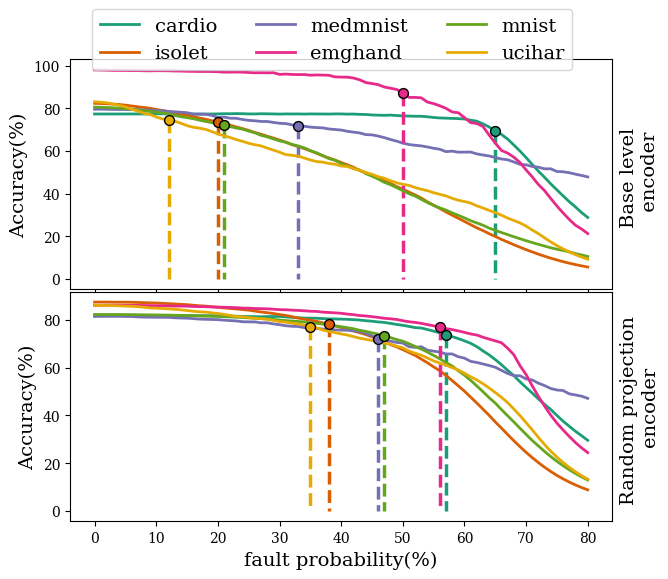

In [60]:
# DIMENSION = ['2000', '5000', '10000']
# for i in DIMENSION:
#     accuracyFaultGraphCombined(i, 'BaseLevelEncoder', '1')
accuracyFaultGraphCombined('10000', '1')

In [27]:
mc = sns.color_palette("bright", 4)

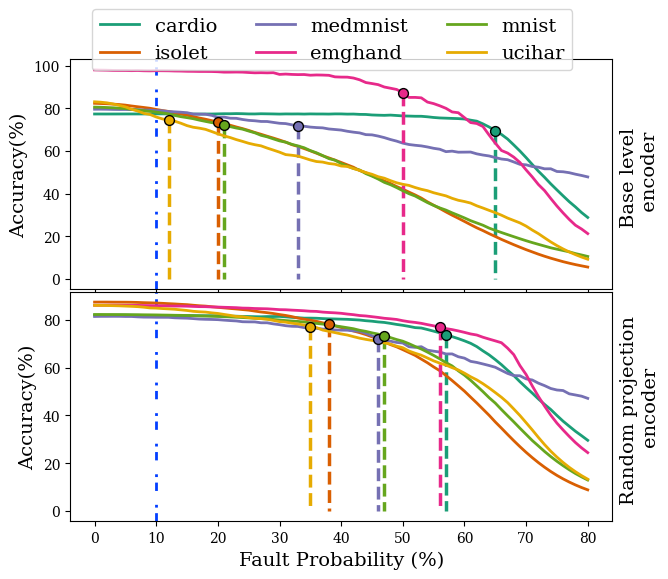

In [32]:
def accuracyFaultGraphCombined(dimension, quantize):
    # Font size variable for easy adjustment
    font_size = 14  # Set this to control all font sizes in the figure

    # Datasets to use
    datasets = ["cardio", "isolet", "medmnist", "emghand", "mnist", "ucihar"]

    # Encoder types
    ENCODER = ['BaseLevelEncoder', 'RandomProjectionEncoder']

    # Use Seaborn color palette for better colors
    colors = sns.color_palette('Dark2', len(datasets))

    # Create a figure with 2 subplots, stacked vertically
    fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

    # Store handles and labels for a single legend
    lines = []

    # Loop over each subplot and encoder type
    for ax, encoder in zip(axs, ENCODER):
        # Add a vertical red line at fault_probability = 10%
        ax.axvline(
            x=10,  # Fault probability is at 10%
            color=mc[0],  # Line color
            linestyle=(0, (3, 2, 1, 5)),  # Solid line
            linewidth=2,  # Line thickness
            label='Fault Probability = 10%'  # Add a label for the red line
        )

        # Plot the data for each dataset
        for j, data in enumerate(datasets):
            # Assuming readExcelForAverage is a function that reads and returns the accuracy data
            accuracies = readExcelForAverage(dimension, encoder, quantize, data)
            fault_rates = list(range(len(accuracies)))  # fault probabilities indexed

            # Plot the accuracy line
            line, = ax.plot(fault_rates, accuracies, label=data, color=colors[j], linewidth=2)
            if encoder == 'BaseLevelEncoder':  # Collect line handles and labels only once (for the first subplot)
                lines.append(line)

            # Calculate 90% of the initial accuracy
            initial_accuracy = accuracies[0]
            drop_threshold = initial_accuracy * 0.9

            # Find the first point where accuracy drops below the threshold
            drop_index = None
            for k in range(len(accuracies)):
                if accuracies[k] < drop_threshold:
                    drop_index = k
                    break

            # Draw a vertical dashed line starting from the accuracy value downwards to the x-axis if the drop point is found
            if drop_index is not None:
                # Plot the vertical dashed line
                ax.plot(
                    [fault_rates[drop_index], fault_rates[drop_index]],  # x-coordinates for the line
                    [accuracies[drop_index], 0],  # y-coordinates start from the accuracy value down to the x-axis (y=0)
                    color=colors[j], linestyle='--', linewidth=2.5
                )

                # Add a dot at the conjunction point of the dashed line and the accuracy line
                ax.scatter(
                    fault_rates[drop_index], accuracies[drop_index],
                    color=colors[j], edgecolor='black', s=50, zorder=5  # Dot style, size, and visibility
                )

        # Set y-axis label and add subplot identifier
        ax.set_ylabel("Accuracy(%)", fontsize=font_size)
        if encoder == "BaseLevelEncoder":
            label = "Base level \n encoder"
        else:
            label = "Random projection \nencoder"
        ax.text(1.05, 0.5, f'{label}', transform=ax.transAxes, va='center', fontsize=font_size, color='black', rotation=90, ha='center')

    # Set common x-axis label
    axs[-1].set_xlabel('Fault Probability (%)', fontsize=font_size)

    # Create a single legend at the figure level
    fig.legend(
        handles=lines, labels=datasets + ['Fault Probability = 10%'],
        loc='upper center', ncol=len(datasets)/2, fontsize=font_size, bbox_to_anchor=(0.5, 0.98)
    )

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.01)

    # Save the figure
    plt.savefig(f"accuraciesSensitivityCombinedwithredline.pdf", bbox_inches='tight')
    plt.show()

# Example usage
accuracyFaultGraphCombined(dimension='10000', quantize='1')

In [63]:
def genConfidenceMetrics(scores):
    # print(scores.shape)
    if(scores.shape == (10000, 1, 10)):
        scores = scores.reshape(10000, 10)
    if(scores.shape == (624, 1, 2)):
        scores = scores.reshape(624, 2)
    # print(scores.shape)
    max_elements = np.max(scores, axis=1)
    min_elements = np.min(scores, axis=1)
    sorted_elements = np.sort(scores, axis=1)
    max_distances = sorted_elements[:, -1] - sorted_elements[:, -2]
    min_max_distances = max_elements - min_elements
    averages = np.mean(scores, axis=1)
    summation = np.sum(scores, axis=1)
    # entropies = np.apply_along_axis(lambda x: entropy(x / np.sum(x)), axis=1, arr=scores)
    return max_elements, summation, averages, max_distances, min_max_distances, min_elements #, entropies

def calcOverlapfor1d(confidenceMetricBase, confidenceMetricFaultys):
    min_base, max_base = np.min(confidenceMetricBase), np.max(confidenceMetricBase)
    confidences = []
    for faultys in confidenceMetricFaultys:
        # Convert faultys to an array if it's a scalar
        if np.isscalar(faultys):
            faultys = np.array([faultys])
        overlap_scores = np.sum((faultys >= min_base) & (faultys <= max_base))
        confidences.append(1 - (overlap_scores / len(faultys)))
    return np.array(confidences)

# def plotConfidences(DIMENSION, encoder, quantize, dataset, steps, numOfElements):
#     plt.figure()
#     metrics_lists = {key: [] for key in ["max_elements", "min_elements", "max_distances", "min_max_distances", "averages", "summation"]}
#     base = get_data(DIMENSION, encoder, quantize, dataset, "0", "", False)
#     metrics_base = genConfidenceMetrics(base)
#     num_classes = len(base[0])
#     faultyPoints, threshold = 0, (int(DIMENSION) * num_classes * int(quantize) * 0.01 * steps * (numOfElements - 1))
#     # Define metric lists

#     metrics_lists = {key: [] for key in ["max_elements", "min_elements", "max_distances", "min_max_distances", "averages", "summation"]}

#     metrics_base = genConfidenceMetrics(base)
    
#     while faultyPoints < threshold:
#         faulty = get_data(DIMENSION, encoder, quantize, dataset, "1", str(faultyPoints), True)
#         metrics_faulty = genConfidenceMetrics(faulty)
#         for key, value in zip(metrics_lists, metrics_faulty):
#             metrics_lists[key].append(value)
#         faultyPoints += int((int(DIMENSION) * num_classes) / 100)

#     calc_overlap = lambda base, list_: calcOverlapfor1d(base, np.array(list_))
#     summation_base_array = np.array([metrics_base[-1]]) if np.isscalar(metrics_base[-1]) else np.array(metrics_base[-1])
#     summation_list_array = np.array(metrics_lists["summation"])

#     overlaps = {key: calc_overlap(base, metrics_lists[key]) for key, base in zip(metrics_lists, metrics_base)}
#     # overlaps["summation"] = calcOverlap(summation_base_array, summation_list_array)
    
#     accuracy = readExcelForAverage(DIMENSION, encoder, quantize, dataset)
#     print(len(accuracy), len(overlaps["max_elements"]))
    
#     for label, data in zip(["maximum score", "sum of score", "average of score", "distance between two highest scores", 
#                             "max distance between scores", "minimum score"], overlaps.values()):
#         plt.plot(data, label=label)
    
#     plt.xlabel("Error rate")
#     plt.ylabel("Detection rate")
#     plt.title(f"{dataset} D= {DIMENSION} {encoder} quantize = {quantize}, windowSize = 1")
#     plt.legend()
#     plt.savefig(f"{dataset}D={DIMENSION}{encoder}quantize={quantize}windowSize=1.png")
    


81 32


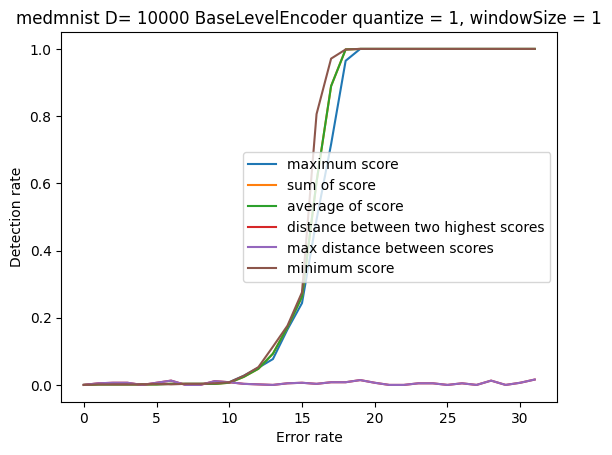

In [441]:
plotConfidences('10000', 'BaseLevelEncoder', '1', 'medmnist', 4 , 9)

In [442]:
datasets = ["cardio", "isolet", "medmnist", "mnist", "ucihar"]
#plotConfidencesWithWindow_separated("10000", "RandomProjectionEncoder", "1", datasets,  1 , 79)

In [4]:
def confidences(DIMENSION, encoder, quantize, dataset):
    
    metrics_lists = {key: [] for key in ["max_elements", "min_elements", "max_distances", "min_max_distances", "averages", "summation"]}
    base = get_data(DIMENSION, encoder, quantize, dataset, "0", "", False)
    metrics_base = genConfidenceMetrics(base)
    num_classes = len(base[0])
    faultyPoints, threshold = 0, (int(DIMENSION) * num_classes * int(quantize) * 0.01 * 35)

    metrics_base = genConfidenceMetrics(base)
    
    while faultyPoints < threshold:
        faulty = get_data(DIMENSION, encoder, quantize, dataset, "1", str(faultyPoints), True)
        metrics_faulty = genConfidenceMetrics(faulty)
        for key, value in zip(metrics_lists, metrics_faulty):
            metrics_lists[key].append(value)
        faultyPoints += int((int(DIMENSION) * num_classes) / 100)
    
    calc_overlap = lambda base, list_: calcOverlapfor1d(base, np.array(list_))
    
    overlaps = {key: calc_overlap(base, metrics_lists[key]) for key, base in zip(metrics_lists, metrics_base)}
    # overlaps["summation"] = calcOverlap(summation_base_array, summation_list_array)
    
    return overlaps
    
def pltConfidencesCombined(dimension, quantize, encoder):
    
    # Datasets to use
    datasets = ["mnist", "cardio", "isolet", "emghand", "ucihar", "medmnist"]

    # Metrics to use
    metrics = ["maximum score", "sum of score", "average of score", 
                "distance between two highest scores", "max distance between scores", "minimum score"]

    # Assign a unique color to each metric
    colors = sns.color_palette('Dark2', len(metrics))
    # Font size variable for easy adjustment
    font_size = 14  # Set this to control all font sizes in the figure

    # Create a figure with 6 subplots, stacked vertically
    fig, axs = plt.subplots(6, 1, figsize=(6, 7), sharex=True)
    
    # Flatten axs to simplify iteration (since it's a 2x3 grid)
    axs = axs.flatten()
    
    # Store handles for creating a single legend
    lines = []

    # Loop through each dataset and axis
    for ax, dataset in zip(axs, datasets):
        # Plot the data for each dataset with specific colors for each metric
        overlaps = confidences(dimension, encoder, quantize, dataset)
        
        # Iterate over each metric for confidence plotting
        for metric, data, color in zip(metrics, overlaps.values(), colors):
            line, = ax.plot(data, label=metric, color=color, linewidth=1.6)
            # Append the line handle to lines list only once (to use for the unified legend)
            if dataset == datasets[0]:  # Only add the first dataset lines for the legend
                lines.append(line)
            
            # Add vertical line where the value is equal to 1, but only for the first occurrence
            for idx, value in enumerate(data):
                if value == 1:
                    ax.axvline(x=idx, color=color, linestyle='--', linewidth=1)
                    # Optional: add a marker to the line
                    ax.plot(idx, value, 'o', color=color, markeredgecolor='black', markeredgewidth=0.5)
                    break  # Stop after finding the first occurrence

        # Remove subplot legend and add dataset label on the right side of the plot
        ax.legend().remove()
        ax.text(1.02, 0.5, f'{dataset}', transform=ax.transAxes, va='center', fontsize = font_size, color='black', rotation=90)

    # Set common x-axis and y-axis labels
    axs[-1].set_xlabel('fault probability (%)', fontsize = font_size)
    # axs[-1].set_ylabel('Detection rate', fontsize = font_size, loc='center')
    fig.text(-0.03, 0.5, 'Detection rate', va='center', rotation='vertical', fontsize=font_size)

    # Create a single legend at the top of the figure
    #fig.legend(handles=lines, labels=metrics, loc='upper center', ncol=2, fontsize = font_size-2, bbox_to_anchor=(0.48, 1.06))
    legend = fig.legend(handles=lines, labels=metrics, loc='upper center', ncol=2, fontsize=font_size-2, bbox_to_anchor=(0.48, 1.06))

    # Making specific items in the legend bold
    for text in legend.get_texts():
        if text.get_text() in ["maximum score", "sum of score", "average of score", "minimum score"]:
            text.set_fontweight('bold')

    # for idx, text in enumerate(fig.legend.get_texts()):
    #     if idx  in ["maximum score", "sum of score", "average of score", 
    #             "distance between two highest scores", "max distance between scores", "minimum score"]:  # Makes every other item bold
    #         text.set_fontweight('bold')
    # Adjust layout to reduce space between plots
    plt.tight_layout()
    fig.subplots_adjust(top=0.92, hspace=0.06)

    # Save the figure with a unique filename per dimension
    plt.savefig("detectionRateCombined.pdf",bbox_inches='tight')
    plt.show()

In [67]:
def genEverything(DIMENSION, encoder, quantize, dataset,  steps, numOfElements):
    loadNonFaulty = get_data(DIMENSION, encoder, quantize, dataset,"0", "", False)
    
    max_elements_base, min_elements_base, max_distances_base, min_max_distances_base, averages_base, summation_base = genConfidenceMetrics(loadNonFaulty)
    
    num_classes = len(loadNonFaulty[0])
    
    all_averages_list_all_ten = []  
    all_max_elements_list_all_ten = []   
    faulty_averages = []  
    faulty_max_elements = []          
    for i in range(10):
    #     print("i :   ", i)
        windowSize = 1
        # faultyPoints = 0
        all_max_elements_list = []
        all_averages_list = []
        # i = 1
        while windowSize <65:
            # print("windowSize : ", windowSize)
            faultyPoints = 0
            max_elements_list = []
            averages_list = []
            # *(0.01)*(100/steps)*(numOfElements-1)   print(((int(DIMENSION)*num_classes*int(quantize))*(0.01)*steps*numOfElements)-0.01, (int(DIMENSION)*num_classes*int(quantize))*(0.8))
            while faultyPoints < ((int(DIMENSION)*num_classes*int(quantize))*(0.01)*(steps)*(numOfElements-1)):
                # print(faultyPoints, " ----- ")
                nparrayfaulty = get_data(DIMENSION, encoder, quantize, dataset,str(i), str(int(faultyPoints)), True)
                
                max_element_windowT, averages_windowT = genConfidenceMetricsWithWindow(nparrayfaulty, windowSize)
                # print(windowSize, len(max_element_windowT))
                max_elements_list.append(max_element_windowT)
                averages_list.append(averages_windowT)
                # print("len(averages_list)       --------        ", len(averages_list))
                faultyPoints = int(faultyPoints + (((int(DIMENSION))*num_classes*(int(quantize)))/math.ceil((100/steps))))
                # print(faultyPoints, " ++++ ",  (((int(DIMENSION))*num_classes*(int(quantize)))/(100/steps)), int(DIMENSION), num_classes, quantize,(100/steps))
                                
            all_max_elements_list.append(max_elements_list)
            all_averages_list.append(averages_list)
            windowSize = windowSize *2
            
        all_averages_list_all_ten.append(all_averages_list)  
        all_max_elements_list_all_ten.append(all_max_elements_list)   
        
    faulty_averages = np.mean(np.array(all_averages_list_all_ten), axis = 0)

In [433]:

# datasets = ['isolet', 'mnist', 'ucihar', 'emghand']
# for data in datasets:
#     genEverything('10000', 'BaseLevelEncoder', '1', data, 10 , 9)
genEverything('1000', 'BaseLevelEncoder', '1', 'emghand', 4 , 9)

In [74]:
accuracy = readExcelForAverage('1000', 'BaseLevelEncoder', '8', 'ucihar')
print(len(accuracy))
print(accuracy)
print(accuracy[::10])


80
[7.94027805e-01 7.17543268e-01 7.04818451e-01 6.49507976e-01
 6.38954878e-01 6.04513067e-01 5.85476762e-01 6.03834403e-01
 5.86935878e-01 5.59789619e-01 5.40074646e-01 5.43535811e-01
 5.38717344e-01 5.35188332e-01 5.59619957e-01 4.68374619e-01
 4.72141168e-01 4.42314216e-01 4.75568372e-01 4.58432302e-01
 4.59077024e-01 4.51747537e-01 4.39226326e-01 4.58805561e-01
 3.90261281e-01 4.00610793e-01 3.95656601e-01 3.92365113e-01
 4.24940616e-01 4.06549034e-01 4.33186284e-01 4.00033934e-01
 3.16389549e-01 3.39192399e-01 3.96810317e-01 3.63250762e-01
 3.49406172e-01 3.72650157e-01 3.61350523e-01 3.09806587e-01
 3.38513745e-01 3.31828977e-01 3.14149985e-01 3.41194436e-01
 3.46623684e-01 2.99898198e-01 2.83542587e-01 2.61757717e-01
 3.08551072e-01 2.82694262e-01 2.80624363e-01 2.71360707e-01
 2.65761791e-01 2.77332887e-01 2.86732270e-01 2.81269087e-01
 2.48456052e-01 2.45639633e-01 2.29793008e-01 1.92772308e-01
 2.04241602e-01 1.90295215e-01 1.84967764e-01 2.16457412e-01
 1.87580590e-01 1.861

In [ ]:
DIMENSION = ['1000', '5000', '10000']
quantize = ['1', '8']
encoders = ['BaseLevelEncoder', 'RandomProjectionEncoder']

In [68]:
def find_closest_indices(values, indicator, thresholds):
    # Calculate target values based on the given indicator and thresholds
    target_values = [indicator * (1 - threshold / 100) for threshold in thresholds]
    
    # Initialize a list to store the closest indices for each threshold
    closest_indices = [None] * len(thresholds)
    
    # Initialize a list to store the minimum differences for each threshold
    min_diffs = [float('inf')] * len(thresholds)
    
    # Iterate through each value in the list
    for i, value in enumerate(values):
        # Check each threshold
        for j, target in enumerate(target_values):
            diff = abs(value - target)
            
            # Update the closest index if a smaller difference is found
            if diff < min_diffs[j]:
                min_diffs[j] = diff
                closest_indices[j] = i
    
    return closest_indices

# Example usage
values = [100, 95, 90, 85, 80, 75]  # Replace with your list of values
indicator = 100
thresholds = [5, 10, 20]

closest_indices = find_closest_indices(values, indicator, thresholds)
print("Indices with closest values to thresholds:", closest_indices)

Indices with closest values to thresholds: [1, 2, 4]


In [3]:
def genConfidenceMetricsForDistribution(scores):
    # print(scores.shape)
    if(scores.shape == (10000, 1, 10)):
        scores = scores.reshape(10000, 10)
    if(scores.shape == (624, 1, 2)):
        scores = scores.reshape(624, 2)
    # print(scores.shape)
    max_elements = np.max(scores, axis=1)
    min_elements = np.min(scores, axis=1)
    averages = np.mean(scores, axis=1)
    return max_elements, averages, min_elements

def find_closest_indices(values, thresholds):
    # Calculate target values based on the given indicator and thresholds
    target_values = [values[0] * (1 - threshold / 100) for threshold in thresholds]
    
    # Initialize a list to store the closest indices for each threshold
    closest_indices = [None] * len(thresholds)
    
    # Initialize a list to store the minimum differences for each threshold
    min_diffs = [float('inf')] * len(thresholds)
    
    # Iterate through each value in the list
    for i, value in enumerate(values):
        # Check each threshold
        for j, target in enumerate(target_values):
            diff = abs(value - target)
            
            # Update the closest index if a smaller difference is found
            if diff < min_diffs[j]:
                min_diffs[j] = diff
                closest_indices[j] = i
    
    return closest_indices

def pltDistributionToError(DIMENSION, encoder, quantize, dataset):
    font_size = 20  
    colors = sns.color_palette('Dark2')
    metrics_lists = {key: [] for key in ["max_score", "averages", "min_score"]}
    
    # base = get_data(DIMENSION, encoder, quantize, dataset, "0", "", False)
    # for key, value in zip(metrics_lists, base):
    #         metrics_lists[key].append(value)
        
    num_classes = 10
    faultyPoints = 0
    accuracies = readExcelForAverage(DIMENSION, encoder, quantize, dataset)    
    thresholds = [0 , 2, 5]# , 1 , 10]
    indices = find_closest_indices(accuracies, thresholds)
    print(indices)
    for faultyIndices in indices: 
        
        faultyPoints = int((int(DIMENSION) * num_classes) / 100 * faultyIndices)
        # print(faultyPoints)
        faulty = get_data(DIMENSION, encoder, quantize, dataset, "1", str(faultyPoints), True)
        metrics_faulty = genConfidenceMetricsForDistribution(faulty)
        for key, value in zip(metrics_lists, metrics_faulty):
            metrics_lists[key].append(value)
        
    # print(metrics_lists)
    labels = ["fault-free", "2% accuracy drop", "5% accuracy drop"] #, "1% accuracy drop",  "10% accuracy drop"]
    
    # Define the number of subplots based on the number of elements in the dictionary
    num_elements = len(metrics_lists)
    print(len(metrics_lists["max_score"]))
    # Create a figure with a subplot for each dictionary element
    fig, axes = plt.subplots(num_elements, 1, figsize=(9, 6), sharex=True)
    
    # Handle the case where there is only one subplot to avoid index errors
    if num_elements == 1:
        axes = [axes]
    
    # Plot each dictionary element in a separate subplot
    for idx, (key, arrays) in enumerate(metrics_lists.items()):
        for i, array in enumerate(arrays):
            axes[idx].hist(array, bins="auto", density=True, histtype='barstacked', alpha=0.1*(9-i),
                            linewidth=4,  label=labels[i] , weights=None, color=colors[i])
            # kde = gaussian_kde(array, bw_method=0.2)
            # x_vals = np.linspace(min(array), max(array), 100)
            # y_vals = kde(x_vals)
            
            # # Plot the smooth line with the specified alpha for transparency
            # axes[idx].plot(x_vals, y_vals, label=labels[i], alpha=0.9)
        # Set title on the right side of each subplot
        # axes[idx].set_title(key, loc='right', rotation='vertical', fontsize=font_size)
        axes[idx].text(1.00, 0.5, key, transform=axes[idx].transAxes, 
                        rotation='vertical', fontsize=font_size, va='center')
        axes[idx].get_yaxis().set_visible(False)
        # Set labels for clarity
    
    # Common x-axis label
    axes[-1].set_xlabel("Score value distribution", fontsize = font_size)
    fig.text(-0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=font_size)

    # Add a single legend on top
    fig.legend(labels=labels, loc='upper center', ncol=4, fontsize = font_size-4, bbox_to_anchor=(0.48, 1.01))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for legend
    fig.subplots_adjust(top=0.92, hspace=0.06)
    plt.savefig("distributionToError"+dataset+".pdf",bbox_inches='tight')
    plt.show()
    


    # # Adjust layout to reduce space between plots
    # plt.tight_layout()
    # fig.subplots_adjust(top=0.92, hspace=0.06)

    # # Save the figure with a unique filename per dimension
    # plt.savefig("detectionRateCombined.pdf",bbox_inches='tight')
    # plt.show()

[0, 6, 10]
3


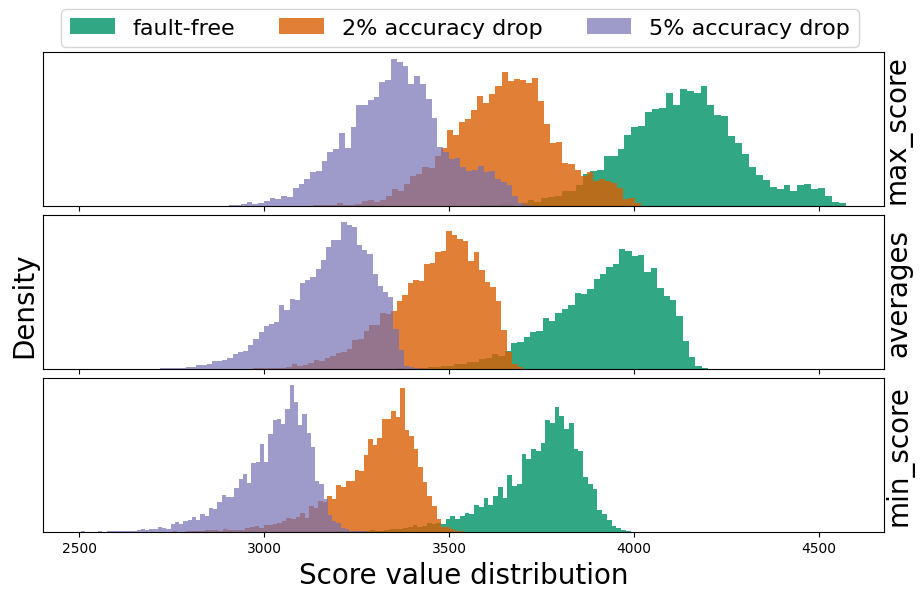

In [4]:
pltDistributionToError('5000',  'BaseLevelEncoder', '1', 'mnist')

In [ ]:
def genConfidenceMetricsForDistribution(scoresmnist, scoreucihar, scoreisolet):
    # print(scores.shape)
    if(scoresmnist.shape == (10000, 1, 10)):
        scoresmnist = scoresmnist.reshape(10000, 10)
    if(scores.shape == (624, 1, 2)):
        scores = scores.reshape(624, 2)
    # print(scores.shape)
    max_elementsmnist = np.max(scoresmnist, axis=1)
    max_elementsucihar = np.max(scoreucihar, axis=1)
    max_elementsisolet = np.max(scoreisolet, axis=1)
    return max_elementsmnist, max_elementsucihar, max_elementsisolet
def pltDistributionToErrorForDatasets(DIMENSION, encoder, quantize, dataset):
    font_size = 20  
    colors = sns.color_palette('Dark2')
    
    metrics_lists = {key: [] for key in ["mnist", "ucihar", "isolet"]}
    
    # base = get_data(DIMENSION, encoder, quantize, dataset, "0", "", False)
    # for key, value in zip(metrics_lists, base):
    #         metrics_lists[key].append(value)
        
    num_classes = 10
    faultyPoints = 0
    accuracies = readExcelForAverage(DIMENSION, encoder, quantize, "")    
    accuracies = readExcelForAverage(DIMENSION, encoder, quantize, "")    
    accuracies = readExcelForAverage(DIMENSION, encoder, quantize, "")    
    thresholds = [0 , 2, 5]# , 1 , 10]
    indices = find_closest_indices(accuracies, thresholds)
    indices = find_closest_indices(accuracies, thresholds)
    indices = find_closest_indices(accuracies, thresholds)
    print(indices)
    for faultyIndices in indices: 
        
        faultyPoints = int((int(DIMENSION) * num_classes) / 100 * faultyIndices)
        # print(faultyPoints)
        faultymnist = get_data(DIMENSION, encoder, quantize, 'mnist', "1", str(faultyPoints), True)
        faultyucihar = get_data(DIMENSION, encoder, quantize, 'ucihar', "1", str(faultyPoints), True)
        faultyisolet = get_data(DIMENSION, encoder, quantize, 'isolet', "1", str(faultyPoints), True)
        metrics_faulty = genConfidenceMetricsForDistribution(faultymnist, faultyucihar, faultyisolet)
        for key, value in zip(metrics_lists, metrics_faulty):
            metrics_lists[key].append(value)
        
    # print(metrics_lists)
    labels = ["fault-free", "2% accuracy drop", "5% accuracy drop"] #, "1% accuracy drop",  "10% accuracy drop"]
    
    # Define the number of subplots based on the number of elements in the dictionary
    num_elements = len(metrics_lists)
    print(len(metrics_lists["max_score"]))
    # Create a figure with a subplot for each dictionary element
    fig, axes = plt.subplots(num_elements, 1, figsize=(9, 6), sharex=True)
    
    # Handle the case where there is only one subplot to avoid index errors
    if num_elements == 1:
        axes = [axes]
    
    # Plot each dictionary element in a separate subplot
    for idx, (key, arrays) in enumerate(metrics_lists.items()):
        for i, array in enumerate(arrays):
            axes[idx].hist(array, bins="auto", density=True, histtype='barstacked', alpha=0.1*(9-i),
                            linewidth=4,  label=labels[i] , weights=None, color=colors[i])
            # kde = gaussian_kde(array, bw_method=0.2)
            # x_vals = np.linspace(min(array), max(array), 100)
            # y_vals = kde(x_vals)
            
            # # Plot the smooth line with the specified alpha for transparency
            # axes[idx].plot(x_vals, y_vals, label=labels[i], alpha=0.9)
        # Set title on the right side of each subplot
        # axes[idx].set_title(key, loc='right', rotation='vertical', fontsize=font_size)
        axes[idx].text(1.00, 0.5, key, transform=axes[idx].transAxes, 
                        rotation='vertical', fontsize=font_size, va='center')
        axes[idx].get_yaxis().set_visible(False)
        # Set labels for clarity
    
    # Common x-axis label
    axes[-1].set_xlabel("Score value distribution", fontsize = font_size)
    fig.text(-0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=font_size)

    # Add a single legend on top
    fig.legend(labels=labels, loc='upper center', ncol=4, fontsize = font_size-4, bbox_to_anchor=(0.48, 1.01))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for legend
    fig.subplots_adjust(top=0.92, hspace=0.06)
    plt.savefig("distributionToError"+dataset+".pdf",bbox_inches='tight')
    plt.show()
    


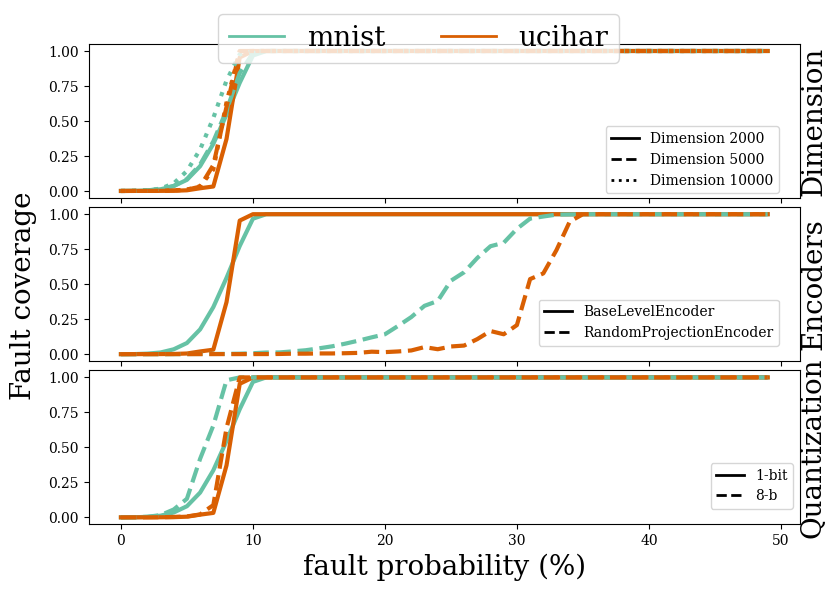

In [33]:
def genConfidenceMetricsAverage(scores):
    # print(scores.shape)
    if(scores.shape == (10000, 1, 10)):
        scores = scores.reshape(10000, 10)
    if(scores.shape == (624, 1, 2)):
        scores = scores.reshape(624, 2)
    # print(scores.shape)
    averages = np.mean(scores, axis=1)
    return  averages

def calcOverlapfor1d(confidenceMetricBase, confidenceMetricFaultys):
    min_base, max_base = np.min(confidenceMetricBase), np.max(confidenceMetricBase)
    # print(np.min(confidenceMetricBase), np.max(confidenceMetricBase))
    confidences = []
    for faultys in confidenceMetricFaultys:
        overlap_scores = np.sum((faultys >= min_base) & (faultys <= max_base))
        confidences.append(1-(overlap_scores / len(faultys)))
    # print(" ========== ")
    return np.array(confidences)

def confidences(DIMENSION, encoder, quantize, dataset):
    metrics_faulty = []
    base = get_data(DIMENSION, encoder, quantize, dataset, "0", "", False)
    num_classes = len(base[0])
    metrics_base = genConfidenceMetricsAverage(base)
    faultyPoints, threshold = 0, (int(DIMENSION) * num_classes * int(quantize) * 0.01 * 50)

    
    while faultyPoints < threshold:
        faulty = get_data(DIMENSION, encoder, quantize, dataset, "1", str(faultyPoints), True)
        metrics_faulty.append(genConfidenceMetricsAverage(faulty))
        faultyPoints += int((int(DIMENSION) * num_classes)*int(quantize) / 100)
        
    overlaps = calcOverlapfor1d(metrics_base, metrics_faulty)
    # overlaps["summation"] = calcOverlap(summation_base_array, summation_list_array)
    
    return overlaps

# Data parameters
datasets = ["mnist", "ucihar"]
DIMENSIONS = ['2000', '5000', '10000']
quantizes = ['1', '8']
encoders = ['BaseLevelEncoder', 'RandomProjectionEncoder']
font_size = 20
# Plot settings
group_colors = {'mnist': 'blue', 'ucihar': 'green'}
line_styles = ['-', '--', ':', '-.']  # To distinguish different options

# Prepare the figure with 3 subplots for each option
fig, axes = plt.subplots(3, 1, figsize=(8, 6))

group_colors = {'mnist': (0.4, 0.7607843137254902, 0.6470588235294118), 'ucihar': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}

# 0.8509803921568627, 0.37254901960784315, 0.00784313725490196
# 0.9019607843137255, 0.6705882352941176, 0.00784313725490196

for i, dimension in enumerate(DIMENSIONS):
    for j, dataset in enumerate(datasets):
        color = group_colors[dataset]
        x = confidences(dimension, encoders[0], quantizes[0], dataset)  # Keep encoder and quantize constant
        axes[0].plot(x,label=f'Dimension={dimension}', linewidth=3, color=color, linestyle=line_styles[i % len(line_styles)])

legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', lw=2, label='Dimension 2000'),
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='Dimension 5000'),
    Line2D([0], [0], color='black', linestyle=':', lw=2, label='Dimension 10000')
]
# axes[0].set_title('Varying Dimension')
axes[0].legend(handles=legend_elements, loc='right', bbox_to_anchor=(0.98, 0.25), ncol=1)

# axes[0].legend(title='Dimensions', loc='upper right')

axes[0].text(1.00, 0.5, "Dimension", transform=axes[0].transAxes, 
                rotation='vertical', fontsize=font_size, va='center')

# Subplot 2: Encoder Varies
for i, encoder in enumerate(encoders):
    for j, dataset in enumerate(datasets):
        color = group_colors[dataset]
        x = confidences(DIMENSIONS[0], encoder, quantizes[0], dataset)  # Keep dimension and quantize constant
        axes[1].plot(x,label=f'Encoder={encoder}', linewidth=3, color=color, linestyle=line_styles[i % len(line_styles)])
axes[1].text(1.00, 0.5, "Encoders", transform=axes[1].transAxes, 
                rotation='vertical', fontsize=font_size, va='center')
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', lw=2, label='BaseLevelEncoder'),
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='RandomProjectionEncoder')
]
# axes[0].set_title('Varying Dimension')
axes[1].legend(handles=legend_elements, loc='right', bbox_to_anchor=(0.98, 0.25), ncol=1)

# Subplot 3: Quantize Varies
for i, quantize in enumerate(quantizes):
    for j, dataset in enumerate(datasets):
        color = group_colors[dataset]
        x = confidences(DIMENSIONS[0], encoders[0], quantize, dataset)  # Keep dimension and encoder constant
        axes[2].plot(x,label=f'Quantize={quantize}', linewidth=3, color=color, linestyle=line_styles[i % len(line_styles)])


axes[2].text(1.00, 0.5, "Quantization", transform=axes[2].transAxes, 
                rotation='vertical', fontsize=font_size, va='center')
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', lw=2, label='1-bit'),
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='8-b')
]
# axes[0].set_title('Varying Dimension')
axes[2].legend(handles=legend_elements, loc='right', bbox_to_anchor=(1, 0.25), ncol=1)

axes[2].set_xlabel('fault probability (%)', fontsize = font_size)
# Create a custom legend for the group colors
group_legend = [Line2D([0], [0], color=color, lw=2, label=group) for group, color in group_colors.items()]
fig.legend(handles=group_legend, loc='upper center', ncol=2, fontsize=font_size)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Reserve space at bottom for the global legend


# axs[-1].set_ylabel('Detection rate', fontsize = font_size, loc='center')
fig.text(-0.04, 0.5, 'Fault coverage', va='center', rotation='vertical', fontsize=font_size)


# Add the manual legend to the figure, positioning it above the image or plots
# bbox_to_anchor specifies the position (x, y, width, height) where x and y are relative to the figure
# loc='lower center' places the legend above the top of the subplots
# Adjust layout to reduce space between plots
plt.tight_layout()
fig.subplots_adjust(top=0.92, hspace=0.06)
plt.savefig("HDCparamiters1.pdf")
plt.show()

In [72]:
def genConfidenceMetricsWithWindow(scores, WindowSize):
    max_elements = np.max(scores, axis=1)
    max_element_window = [np.mean(max_elements[i:i + WindowSize]) for i in range(0, len(max_elements))]
    min_elements = np.min(scores, axis=1)
    min_element_window = [np.mean(max_elements[i:i + WindowSize]) for i in range(0, len(min_elements))]
    averages = np.mean(scores, axis=1)
    # # print ( "Average = ", averages, end = ", ")
    averages_window = [np.mean(averages[i:i + WindowSize])*WindowSize for i in range(0, len(max_elements))]
    return max_element_window, averages_window, min_element_window, max_elements, averages, min_elements

def calcOverlapPercentage(confidenceMetricBase, confidenceMetricFaultys):
    min_base, max_base = np.min(confidenceMetricBase), np.max(confidenceMetricBase)
    overlap_scores = np.sum((confidenceMetricFaultys >= min_base) & (confidenceMetricFaultys <= max_base))
    # print("scores : ", min_base, max_base, np.min(confidenceMetricFaultys), np.max(confidenceMetricFaultys))
    return (1 - (overlap_scores/len(confidenceMetricFaultys)))

def heatmapWithWindowData(DIMENSION, encoder, quantize):
    datasets = ["mnist", "cardio", "isolet", "emghand", "ucihar", "medmnist"]

    windowSize = 1 
    acc = []
    indices = []
    for dataset in (datasets):
        
        base = get_data(DIMENSION, encoder, quantize, dataset, "0", "", False)
        num_classes = len(base[0])
        max_element_windowBase, sum_elements_windowBase, averages_windowBase, max_elementsBase, sum_elementsBase, averagesBase = genConfidenceMetricsWithWindow(base, 1)
        faultyPoints = 0
        accuracies = readExcelForAverage(DIMENSION, encoder, quantize, dataset)    
        # thresholds = [3, 5, 10, 15, 20]
        indices.append([])
        windowSize = 1
        while windowSize < 8:
            for i in range(78):
                faultyPoints = int((int(DIMENSION) * num_classes) / 100 * i)
                faulty = get_data(DIMENSION, encoder, quantize, dataset, "1", str(faultyPoints), True)
                max_element_windowFaulty, sum_elements_windowFaulty, averages_windowFaulty, max_elementsFaulty, sum_elementsFaulty, averagesFaulty = genConfidenceMetricsWithWindow(faulty, windowSize)
                if max(calcOverlapPercentage(max_elementsBase, max_element_windowFaulty), calcOverlapPercentage(sum_elementsBase, sum_elements_windowFaulty), calcOverlapPercentage(averagesBase, averages_windowFaulty)) == 1:
                    # print("window : ", windowSize, " index :", i , calcOverlapPercentage(max_elementsBase, max_element_windowFaulty), calcOverlapPercentage(sum_elementsBase, sum_elements_windowFaulty), calcOverlapPercentage(averagesBase, averages_windowFaulty))
                    # print("scores : ",np.min(averagesBase), np.max(averagesBase), np.min(averages_windowFaulty), np.max(averages_windowFaulty))
                    indices[-1].append(i)
                    break
            windowSize = windowSize *2
        acc.append([accuracies[0]-accuracies[i] for i in indices[-1]]) 
        
    print(np.shape(np.array(acc)) , np.shape(np.array(indices)))
    return (np.array(acc) , np.array(indices))

from matplotlib.colors import LinearSegmentedColormap
def pltHeatmaps(acc, indices):
    font = 16
    color = sns.color_palette('Dark2')
    dark2_cmap = LinearSegmentedColormap.from_list("dark2_cmap", color, N=256)
    # Create the figure and define the subplots
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)  # Two rows, one column
    x_labels = ["mnist", "cardio", "isolet", "emghand", "ucihar", "medmnist"]
    y_labels = [1, 2, 4]
    print(x_labels, y_labels)
    
    # Second subplot for the second heatmap
    sns.heatmap(indices+1, annot=True, cmap=color, ax=axes[1], linewidths=0.5, cbar=True, annot_kws={"fontsize": font-1})
    axes[1].set_title("fault probability (%)", fontsize=font)
    # axes[1].set_yticklabels(y_labels, rotation=45, ha='right')
    
    # First subplot for the first heatmap
    sns.heatmap(acc, annot=True, cmap=color, ax=axes[0], linewidths=0.5, cbar=True, annot_kws={"fontsize": font-1})
    axes[0].set_title("Accuracy drop (%)", fontsize=font)
    axes[0].set_xticklabels(y_labels, fontsize=font)
    axes[1].set_xticklabels(y_labels, fontsize=font)
    axes[0].set_yticklabels(x_labels, rotation=0, fontsize=font)
    fig.text(0.02, 0.05, "window size", fontsize=font)
    # fig.text(1.00003, 0.14, encoder, rotation=90 , fontsize=font, )

    # Adjust the layout to make sure titles and labels are not overlapping
    plt.tight_layout(w_pad=0.5) #plt.tight_layout()
    plt.savefig("100heat"+'RandomProjectionEncoder'+".pdf",bbox_inches='tight')
    plt.show()


In [73]:
print( sns.color_palette('colorblind'))

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.5803921568627451, 0.5803921568627451, 0.5803921568627451), (0.9254901960784314, 0.8823529411764706, 0.2), (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]


In [74]:
acc, indices = heatmapWithWindowData('10000',  'RandomProjectionEncoder', '1')

(6, 3) (6, 3)


['mnist', 'cardio', 'isolet', 'emghand', 'ucihar', 'medmnist'] [1, 2, 4]


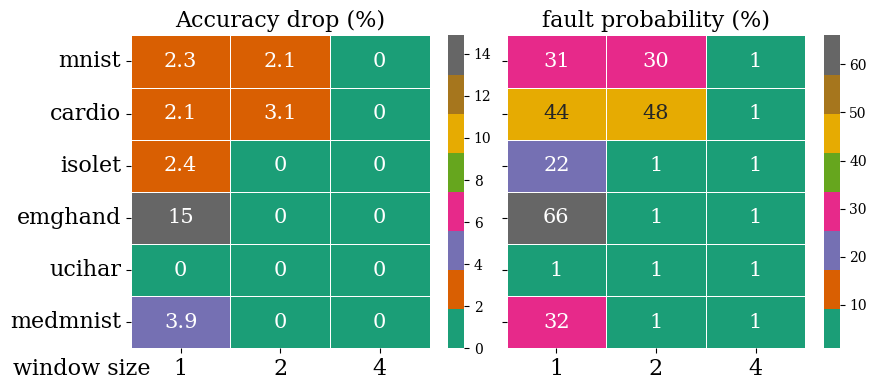

In [75]:
pltHeatmaps(acc, indices)

In [ ]:
def pltDistributionToError(DIMENSION, encoder, quantize, dataset):
    font_size = 20  
    colors = sns.color_palette('Dark2')
    metrics_lists = {key: [] for key in ["max_score", "averages", "min_score"]}
    
    # base = get_data(DIMENSION, encoder, quantize, dataset, "0", "", False)
    # for key, value in zip(metrics_lists, base):
    #         metrics_lists[key].append(value)
        
    num_classes = 10
    faultyPoints = 0
    accuracies = readExcelForAverage(DIMENSION, encoder, quantize, dataset)    
    thresholds = [0 , 1 ,  2, 5]# , 10]
    indices = find_closest_indices(accuracies, thresholds)
    print(indices)
    for faultyIndices in indices: 
        
        faultyPoints = int((int(DIMENSION) * num_classes) / 100 * faultyIndices)
        # print(faultyPoints)
        faulty = get_data(DIMENSION, encoder, quantize, dataset, "1", str(faultyPoints), True)
        metrics_faulty = genConfidenceMetricsWithWindow(faulty, 2)
        for i , key in enumerate(metrics_lists):
            metrics_lists[key].append(metrics_faulty[i])
        
    # print(metrics_lists)
    labels = ["none faulty", "1% accuracy drop", "2% accuracy drop", "5% accuracy drop"] #, "1% accuracy drop",  "10% accuracy drop"]
    
    # Define the number of subplots based on the number of elements in the dictionary
    num_elements = len(metrics_lists)
    print(len(metrics_lists["max_score"]))
    # Create a figure with a subplot for each dictionary element
    fig, axes = plt.subplots(num_elements, 1, figsize=(9, 6), sharex=True)
    
    # Handle the case where there is only one subplot to avoid index errors
    if num_elements == 1:
        axes = [axes]
    
    # Plot each dictionary element in a separate subplot
    for idx, (key, arrays) in enumerate(metrics_lists.items()):
        for i, array in enumerate(arrays):
            axes[idx].hist(array, bins="auto", density=True, histtype='barstacked', alpha=0.1*(9-i),
                            linewidth=4,  label=labels[i] , weights=None, color=colors[i])
            # kde = gaussian_kde(array, bw_method=0.2)
            # x_vals = np.linspace(min(array), max(array), 100)
            # y_vals = kde(x_vals)
            
            # # Plot the smooth line with the specified alpha for transparency
            # axes[idx].plot(x_vals, y_vals, label=labels[i], alpha=0.9)
        # Set title on the right side of each subplot
        # axes[idx].set_title(key, loc='right', rotation='vertical', fontsize=font_size)
        axes[idx].text(1.00, 0.5, key, transform=axes[idx].transAxes, 
                        rotation='vertical', fontsize=font_size, va='center')
        axes[idx].get_yaxis().set_visible(False)
        # Set labels for clarity
    
    # Common x-axis label
    axes[-1].set_xlabel("Score value distribution", fontsize = font_size)
    fig.text(-0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=font_size)

    # Add a single legend on top
    fig.legend(labels=labels, loc='upper center', ncol=4, fontsize = font_size-4, bbox_to_anchor=(0.48, 1.01))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for legend
    fig.subplots_adjust(top=0.92, hspace=0.06)
    plt.savefig("distributionToError"+dataset+".pdf",bbox_inches='tight')
    plt.show()
    

[0, 4, 6, 10]
4


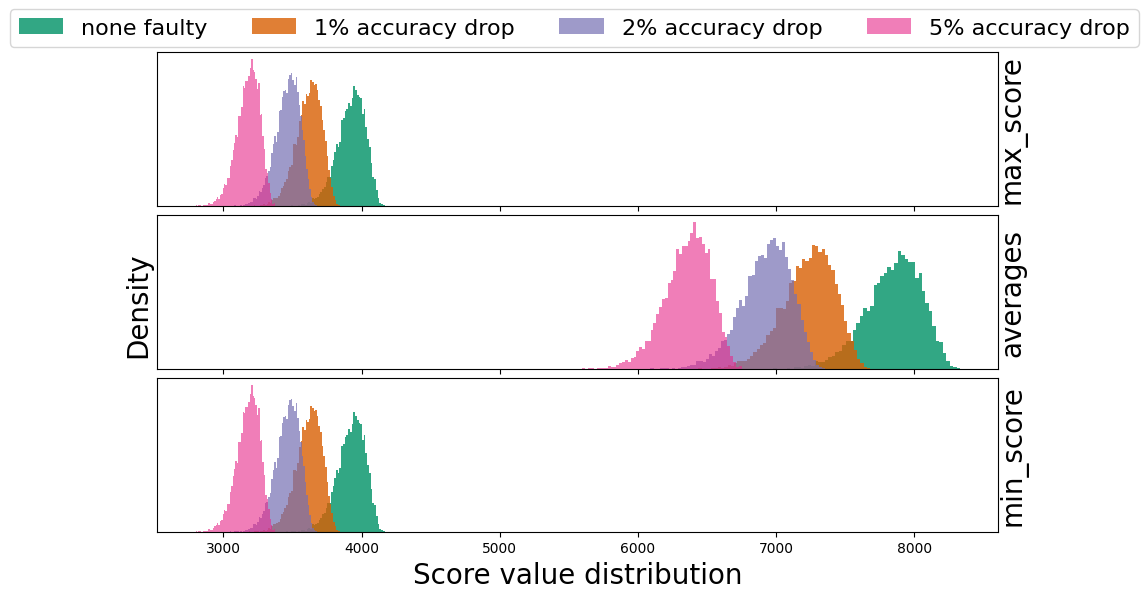

In [794]:
pltDistributionToError('5000',  'BaseLevelEncoder', '1', 'mnist')

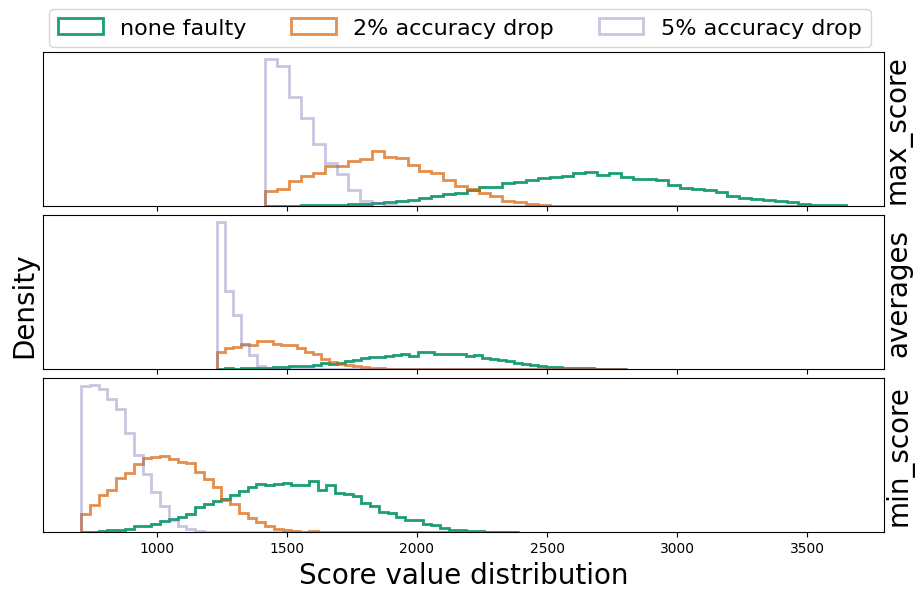

In [698]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde

def pltDistributionToError1(DIMENSION, encoder, quantize, dataset):
    font_size = 20  
    colors = sns.color_palette('Dark2')
    metrics_lists = {key: [] for key in ["max_score", "averages", "min_score"]}
    
    num_classes = 10
    faultyPoints = 0
    accuracies = readExcelForAverage(DIMENSION, encoder, quantize, dataset)    
    thresholds = [0, 2, 5]
    indices = find_closest_indices(accuracies, thresholds)
    for faultyIndices in indices: 
        faultyPoints = int((int(DIMENSION) * num_classes) / 100 * faultyIndices)
        faulty = get_data(DIMENSION, encoder, quantize, dataset, "1", str(faultyPoints), True)
        metrics_faulty = genConfidenceMetricsForDistribution(faulty)
        for key, value in zip(metrics_lists, metrics_faulty):
            metrics_lists[key].append(value)

    labels = ["none faulty", "2% accuracy drop", "5% accuracy drop"]
    num_elements = len(metrics_lists)
    fig, axes = plt.subplots(num_elements, 1, figsize=(9, 6), sharex=True)

    if num_elements == 1:
        axes = [axes]

    for idx, (key, arrays) in enumerate(metrics_lists.items()):
        # Calculate the histogram for "none faulty" as a reference
        none_faulty_hist, bin_edges = np.histogram(arrays[0], bins="auto", density=True)

        for i, array in enumerate(arrays):
            # Gradual transparency adjustment for overlap visualization
            if i == 0:
                alpha = 1.0  # Full opacity for the "none faulty" distribution
            else:
                alpha = 1.0 - (i * 0.3)  # Gradually reduce alpha for each subsequent distribution
            
            # Plot the histogram using step style for better visibility of overlaps
            axes[idx].hist(array, bins=bin_edges, density=True, histtype='step', alpha=alpha,
                           linewidth=2, label=labels[i], color=colors[i])
            
        axes[idx].text(1.00, 0.5, key, transform=axes[idx].transAxes, 
                       rotation='vertical', fontsize=font_size, va='center')
        axes[idx].get_yaxis().set_visible(False)

    axes[-1].set_xlabel("Score value distribution", fontsize=font_size)
    fig.text(-0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=font_size)
    fig.legend(labels=labels, loc='upper center', ncol=4, fontsize=font_size-4, bbox_to_anchor=(0.48, 1.01))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.subplots_adjust(top=0.92, hspace=0.06)
    plt.savefig("distributionToError" + dataset + "1.pdf", bbox_inches='tight')
    plt.show()
    
pltDistributionToError1('5000',  'RandomProjectionEncoder', '1', 'mnist')


In [673]:
/model_retraining/models/mnist/BaseLevelEncoder/norma
/model_retraining/models/MNIST/BaseLevelEncoder/normal/qua

NameError: name 'model_retraining' is not defined

In [491]:
ls

 accuraciesSensitivityCombined_DIMENSION_10000.pdf
 accuraciesSensitivityCombined_DIMENSION_2000.pdf
 accuraciesSensitivityCombined_DIMENSION_5000.pdf
 accuraciesSensitivityCombined.pdf
 accuraciesSensivity.pdf
 accuracyExcel/
 accuracy.jpg
 basemodels_excels/
'cardioD=10000BaseLevelEncoderquantize=1windowSize=1.png'
 data/
 detectionRateCombined11.pdf
 detectionRateCombined.pdf
'emghandD=10000BaseLevelEncoderquantize=1windowSize=1.png'
 fault_analizer_final_directories.ipynb
 generate_files_for_datasets_fault_detection.ipynb
 hardware_results.ods
 HDC_with_detection/
'heap_emghandD=10000BaseLevelEncoderquantize=1withmax_elementsdetection.png'
'heap_emghandD=10000BaseLevelEncoderquantize=1withsummationdetection.png'
'heap_emghandD=1000BaseLevelEncoderquantize=1withmax_elementsdetection.png'
'heap_emghandD=1000BaseLevelEncoderquantize=1withsummationdetection.png'
'heap_isoletD=10000BaseLevelEncoderquantize=1withmax_elementsdetection.png'
'heap_isoletD=10000BaseLevelEncoderquantize=1with